# Learning-to-rank using the WARP loss

LightFM is probably the only recommender package implementing the WARP (Weighted Approximate-Rank Pairwise) loss for implicit feedback learning-to-rank. Generally, it perfoms better than the more popular BPR (Bayesian Personalised Ranking) loss --- often by a large margin.

It was originally applied to image annotations in the Weston et al. [WSABIE paper](http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf), but has been extended to apply to recommendation settings in the [2013 k-order statistic loss paper](http://www.ee.columbia.edu/~ronw/pubs/recsys2013-kaos.pdf) in the form of the k-OS WARP loss, also implemented in LightFM.

Like the BPR model, WARP deals with (user, positive item, negative item) triplets. Unlike BPR, the negative items in the triplet are not chosen by random sampling: they are chosen from among those negatie items which would violate the desired item ranking given the state of the model. This approximates a form of active learning where the model selects those triplets that it cannot currently rank correctly.

This procedure yields roughly the following algorithm:

1. For a given (user, positive item pair), sample a negative item at random from all the remaining items. Compute predictions for both items; if the negative item's prediction exceeds that of the positive item plus a margin, perform a gradient update to rank the positive item higher and the negative item lower. If there is no rank violation, continue sampling negative items until a violation is found.
2. If you found a violating negative example at the first try, make a large gradient update: this indicates that a lot of negative items are ranked higher than positives items given the current state of the model, and the model must be updated by a large amount. If it took a lot of sampling to find a violating example, perform a small update: the model is likely close to the optimum and should be updated at a low rate.

While this is fairly hand-wavy, it should give the correct intuition. For more details, read the paper itself or a more in-depth blog post [here](https://building-babylon.net/2016/03/18/warp-loss-for-implicit-feedback-recommendation/). A similar approach for BPR is described in Rendle's 2014 [WSDM 2014 paper](http://webia.lip6.fr/~gallinar/gallinari/uploads/Teaching/WSDM2014-rendle.pdf).

Having covered the theory, the rest of this example looks at the practical implications of using WARP in LightFM.

## Preliminaries
Let's first get the data. We'll use the MovieLens 100K dataset.

In [1]:
import time

import numpy as np

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score

movielens = fetch_movielens()

train, test = movielens['train'], movielens['test']

/Users/timwee/anaconda3/lib/python3.5/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


## Accuracy
The first interesting experiment is to compare the accuracy between the WARP and BPR losses. Let's fit two models with equivalent hyperparameters and compare their accuracy across epochs. Whilst we're fitting them, let's also measure how much time each epoch takes.

In [6]:
alpha = 1e-05
epochs = 70
num_components = 32

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    duration=time.time() - start
    print("warp iteration %d took %.2f" % (epoch, duration))
    warp_duration.append(duration)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())
    
for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=1)
    duration=time.time() - start
    print("BPR iteration %d took %.2f" % (epoch, duration))
    bpr_duration.append(duration)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())

warp iteration 0 took 0.20
warp iteration 1 took 0.22
warp iteration 2 took 0.23
warp iteration 3 took 0.23
warp iteration 4 took 0.24
warp iteration 5 took 0.24
warp iteration 6 took 0.24
warp iteration 7 took 0.25
warp iteration 8 took 0.25
warp iteration 9 took 0.26
warp iteration 10 took 0.25
warp iteration 11 took 0.26
warp iteration 12 took 0.25
warp iteration 13 took 0.27
warp iteration 14 took 0.27
warp iteration 15 took 0.27
warp iteration 16 took 0.27
warp iteration 17 took 0.26
warp iteration 18 took 0.29
warp iteration 19 took 0.27
warp iteration 20 took 0.27
warp iteration 21 took 0.28
warp iteration 22 took 0.27
warp iteration 23 took 0.28
warp iteration 24 took 0.28
warp iteration 25 took 0.27
warp iteration 26 took 0.29
warp iteration 27 took 0.28
warp iteration 28 took 0.28
warp iteration 29 took 0.28
warp iteration 30 took 0.28
warp iteration 31 took 0.28
warp iteration 32 took 0.28
warp iteration 33 took 0.28
warp iteration 34 took 0.30
warp iteration 35 took 0.30
wa

In [7]:
warp_model.item_embeddings

array([[ 0.84748149,  0.04784342, -1.13543689, ..., -0.12250341,
         1.25374436, -1.1049825 ],
       [ 1.01982307, -0.37049195,  0.04679989, ...,  0.50105327,
         0.19261554, -0.67930067],
       [ 0.25174725,  0.14984119, -0.77184963, ..., -0.59362203,
         0.17613928, -0.09796087],
       ..., 
       [ 0.12152316,  0.2315637 ,  0.42387742, ..., -0.04079237,
         0.10226785,  0.41685995],
       [ 0.45056206, -0.14189178,  0.21072266, ..., -0.24250311,
        -0.05265095, -0.11069366],
       [ 0.25114712, -0.14947142, -0.05835255, ..., -0.13825577,
         0.16683429,  0.7628724 ]], dtype=float32)

Plotting the results immediately reveals that WARP produces superior results: a smarter way of selecting negative examples leads to higher quality rankings. Test accuracy decreases after the first 10 epochs, suggesting WARP starts overfitting and would benefit from regularization or early stopping.

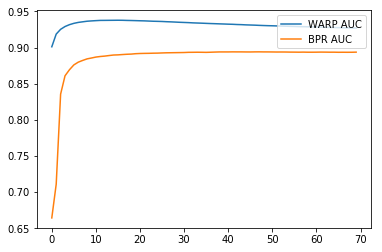

In [3]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

## Fitting speed

What about model fitting speed?

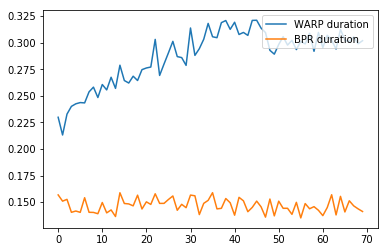

In [4]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.legend(['WARP duration', 'BPR duration'], loc='upper right')
plt.show()

WARP is slower than BPR for all epochs. Interestingly, however, it gets slower with additional epochs; every subsequent epoch takes more time. This is because of WARP's adaptive samling of negatives: the closer the model fits the training data, the more times it needs to sample in order to find rank-violating examples, leading to longer fitting times.

For this reason, LightFM exposes the `max_sampled` hyperparameter that limits the number of attemps WARP will carry out to find a negative. Setting it to a low value and repeating the run shows that the run time actually decreases with every epoch: this is because no updates happen when a violating example cannot be found in the specified number of attempts.

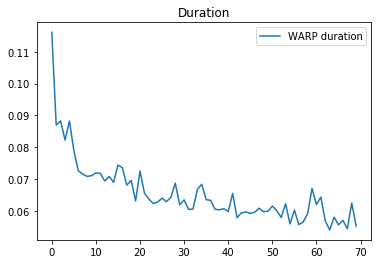

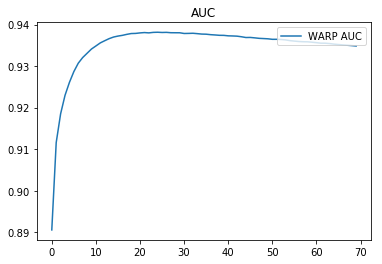

In [5]:
warp_model = LightFM(no_components=num_components,
                     max_sampled=3,
                    loss='warp',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
warp_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.legend(['WARP duration'], loc='upper right')
plt.title('Duration')
plt.show()

x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.legend(['WARP AUC'], loc='upper right')
plt.title('AUC')
plt.show()